# Bot twitter semanal

Este bot genera reportes semanales de la calidad de aire en las últimas 24 horas y se publican en twitter.

In [1]:
# Instalar librerías
"""
!pip install APIMakeSens
!pip install folium
!pip install tweepy
!pip install selenium
"""

'\n!pip install APIMakeSens\n!pip install folium\n!pip install tweepy\n!pip install selenium\n'

### Cómo ejecutar este código automáticamente a una hora específica:

1. Descarga el notebook como un archivo .py.


2. Ejecuta en la terminal sudo nano /etc/crontab.


3. Añade una nueva línea al final del archivo con el siguiente formato:

    \<minuto> \<hora> * * \<dia semana> \<usuario> python3 /ruta/del/script.py

    \<minuto> representa el minuto de la hora en la que deseas ejecutar el comando, \<hora> representa la hora del día en formato 24 horas y \<dia semana> corresponde al día de la semana en que se ejecutará el comando (0-lunes, 1-martes, etc). \<usuario> es el usuario bajo el cual se ejecutará el comando. Asegúrate de reemplazar \<usuario> con el nombre de usuario correcto.
    

4. Guarda y cierra el archivo /etc/crontab.

    Después de guardar los cambios en /etc/crontab, la tarea programada se ejecutará automáticamente según la hora especificada. Recuerda asegurarte de proporcionar la ruta correcta hacia el intérprete de Python (p.ej. /usr/bin/Python3) y la ruta correcta hacia tu script (/ruta/del/script.py). Además, ten en cuenta que el usuario especificado debe tener los permisos adecuados para ejecutar el script y acceder a cualquier archivo o recurso requerido por el script.

    
Finalmente es importante cambiar la ruta de la variable path dentro del código para que desde cron pueda acceder a los diferentes archivos correctamente.

In [2]:
import pandas as pd
import numpy as np
import datetime
import pytz

from MakeSens import MakeSens
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
#plt.rc('text',usetex=True)
#plt.rc('font',size=16)

In [3]:
#fecha_inicio = "2023-06-11 00:00:00"
#fecha_fin = "2023-06-18 00:00:00"

# Rango de fecha
#fechaFin = datetime.datetime.now(pytz.timezone('America/Bogota')).strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia
nowtime = datetime.datetime.combine(datetime.datetime.now(pytz.timezone('America/Bogota')), datetime.datetime.min.time())# Fecha y hora Colombia (medianoche)
fechaFin = nowtime.strftime('%Y-%m-%d %H:%M:%S') # Fecha y hora Colombia (medianoche)
#fechaInicio = fechaFin[:-8]+f'{int(fechaFin[-8:-6])-1:02}'+fechaFin[-6:] # Restar una hora

past_date =  nowtime - datetime.timedelta(days=6)  #Restar 6 días
fechaInicio = past_date.strftime('%Y-%m-%d %H:%M:%S')

Estaciones = [('E2_00023','Grupo Halley',7.1393716,-73.1210968),
            ('mE1_00004','Col. Tecnologico',7.1381572,-73.1180935),
            ('mE1_00005','Col. Santander',7.1385332,-73.121327),
            ('mE1_00007','Col. Normal',7.1277056,-73.116534),
            ('mE1_00006','Col. Pilar',7.108717813305484, -73.12173474310134),
            ('mE1_00008','Col. FundeUis',7.05756, -73.0912)]

frecuencia = "m"

Nest=len(Estaciones)

#Descargamos los datos de MakeSens

In [4]:
wd = 30
ped = int(wd*0.1) 

def hour_mean(est):
    global pm25
    data = MakeSens.download_data(est, fechaInicio, fechaFin, frecuencia)
    
    if not data.empty:
        pm25 = data[["pm25_1", "pm25_2"]].copy(deep=True)
        pm25.index = pd.to_datetime(pm25.index) #Convertimos el indice a formato fecha
        
        pm25.pm25_1 = pm25.pm25_1.where(pm25.pm25_1 < 120, np.nan)
        pm25.pm25_2 = pm25.pm25_2.where(pm25.pm25_2 < 120, np.nan)
        
        pm25['pm25_1_r'] = pm25['pm25_1'].rolling(window=wd, min_periods=ped).mean() 
        pm25['pm25_2_r'] = pm25['pm25_2'].rolling(window = wd,min_periods=ped).mean()
        
        pm25['hour'] = pm25.index.hour
        
        hourly_1 = pm25.pm25_1_r.groupby(pm25.hour).mean()
        hourly_2 = pm25.pm25_2_r.groupby(pm25.hour).mean()
        
        data_final = ((hourly_1+hourly_2)/2.0).to_frame()
        
    else:
        pm25 = data
        data_final = data
    
    return data_final

In [5]:
Week = {
  1: "Lun",
  2: "Mar",
  3: "Mier",
  4: "Jue",
  5: "Vier",
  6: "Sab",
  7: "Dom"
}
Ntotal = int(24*30)

def day_mean(data,j):
    
    if not data.empty:
        data.dropna()
        pm25['day'] = pm25.index.day
        dfw = [ g for _,g in  data.groupby(data.day)]
        
        NN = len(dfw)
        pm25_grid = np.zeros(NN)
        day = []
        for i in range(NN):
            Ndata = dfw[i]['pm25_1'].count()
            day_p = dfw[i].index.isocalendar().day[0]
            
            number = dfw[i].day[0]
            day.append( " _ ".join([Week[day_p], str(number)]) )
            
            if Ndata>0.5*Ntotal:     
                pm25_grid[i] = np.mean([dfw[i]['pm25_1'].mean(),dfw[i]['pm25_2'].mean()])
            else:
                pm25_grid[i] = np.nan
                
        df2 = pd.DataFrame( [ np.array(pm25_grid) ],
                           columns=day)
        
        df2 = df2.set_index( pd.Index( [ Estaciones[j][1] ] ) )
    
    else:
        df2 = data
    
    return  df2

In [6]:
hr_0 = hour_mean(Estaciones[0][0])
hr_0.columns = [Estaciones[0][1]]

day_0 = day_mean(pm25,0)
#day_0 = day_0.set_index( pd.Index( [ Estaciones[0][1] ] ) )
#day_0.head()

In [7]:
for i in range(1,Nest):
    print(Estaciones[i][1])
    hr_1 = hour_mean( Estaciones[i][0] )
    day_1 = day_mean(pm25,i)
    
    if not hr_1.empty:
        hr_1.columns = [ Estaciones[i][1] ] 
        hr_0 = hr_0.join(hr_1)
    
    if not day_1.empty:
        #day_1 = day_1.set_index( pd.Index( [ Estaciones[i][1] ] ) )
        #day_0  = day_0.reset_index()
        #day_1  = day_1.reset_index()
        day_0 = pd.concat([day_0, day_1])


Col. Tecnologico
Col. Santander
Col. Normal
Col. Pilar
Col. FundeUis


In [8]:
# Ruta absoluta para acceder a archivos
#path = '/home/kevin/Repos/BotAir/Bot_twitter/'
path = './'

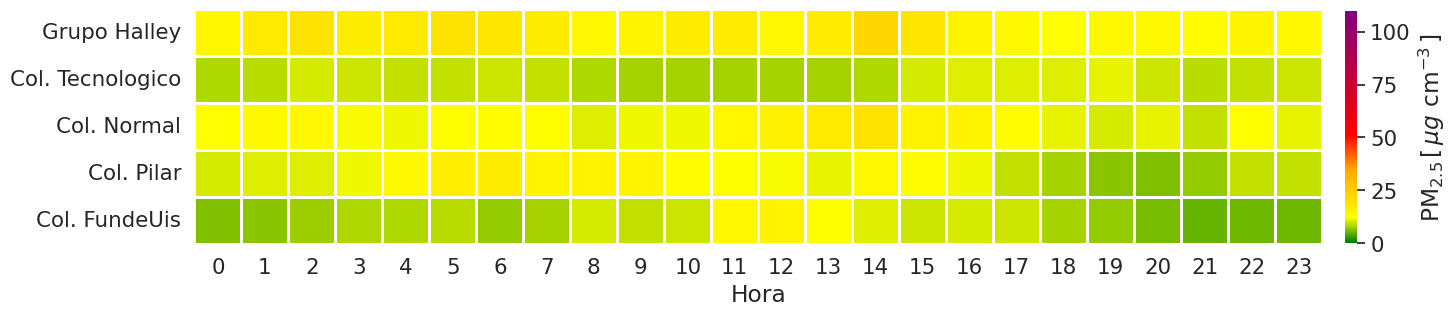

In [9]:
df_all_transposed = hr_0.transpose()

#cvals  = [6,12,37, 55, 100]
cvals  = [0,13, 38, 56, 120]
#colors = ['green', "#c8ff00", 'yellow', 'orange', "red"]
colors = ['green',  'yellow', 'orange', "red", "purple"]

norm=plt.Normalize(min(cvals),max(cvals))
tuples = list(zip(map(norm,cvals), colors))
cmap = LinearSegmentedColormap.from_list('name', tuples)
#cmap = ListedColormap(colors)

sns.set(font_scale=1.4)

plt.figure(figsize=(15,10), facecolor='w', edgecolor='k')
sns.heatmap(df_all_transposed,cmap=cmap,square=True, linewidths=2, vmin=0, vmax=110,
           cbar_kws={'fraction' : 0.01, 'pad': 0.02,'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})
#$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$
plt.yticks(rotation=0) 
plt.xlabel('Hora')

plt.savefig(path+"PlotHora.png", bbox_inches='tight', transparent=True)

#plt.show()

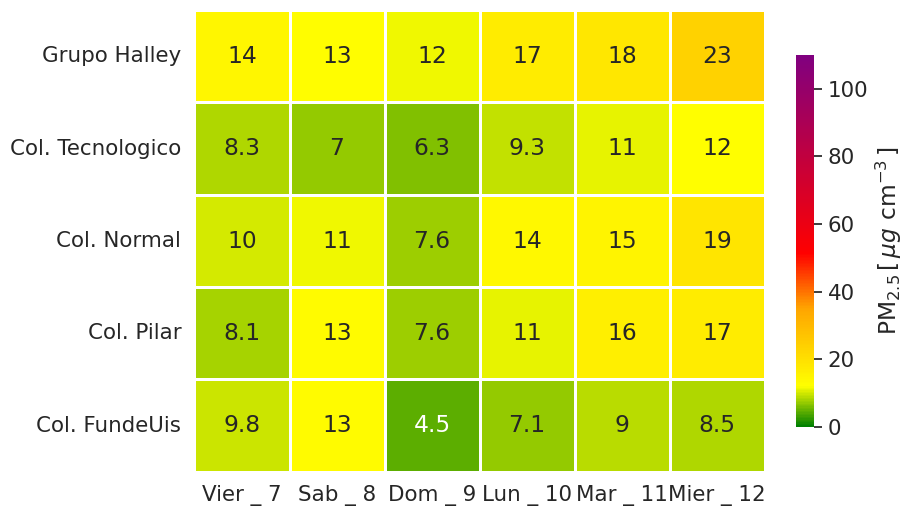

In [10]:
plt.figure(figsize=(8,6), facecolor='w', edgecolor='k')

sns.heatmap(day_0,cmap=cmap,linewidths=2, vmin=0, vmax=110, annot=True,
           cbar_kws={'fraction' : 0.03, 'label': '$\\mathrm{PM}_{2.5}\,  [\,\mu g\, \, \\mathrm{cm}^{-3}\,]$'})


sns.set(font_scale=1.2)

plt.yticks(rotation=0) 
#plt.xlabel('Hora')

plt.savefig(path+"PlotSemana.png", bbox_inches='tight', transparent=True)

#plt.show()

In [14]:
# Convertir mapa a imagen
#bucaramanga_map.save('mapa.html')
import io
from PIL import Image

#img_data = bucaramanga_map._to_png(5)
img = Image.open(path+'PlotSemana.png')
wpercent=0.6
hsize = int((float(img.size[1])*float(wpercent)))
wsize = int((float(img.size[0])*float(wpercent)))
img = img.resize((wsize,hsize))

plantillaW = Image.open(path+'PlantillaSemanal.png') # Debe añadirse manualmente en la plantilla las estaciones a mostrar
plantillaW.paste(img,(6,430), mask= img) # Se une la imagen generada con la plantilla
plantillaW.save(path+'mapaSemana_full.png')

#plantillaW.show()

In [13]:
# Convertir mapa a imagen
#bucaramanga_map.save('mapa.html')
import io
from PIL import Image

#img_data = bucaramanga_map._to_png(5)
img = Image.open(path+'PlotHora.png')
wpercent=0.7
hsize = int((float(img.size[1])*float(wpercent)))
wsize = int((float(img.size[0])*float(wpercent)))
img = img.resize((wsize,hsize))

plantillaH = Image.open(path+'PlantillaHora.png') # Debe añadirse manualmente en la plantilla las estaciones a mostrar
plantillaH.paste(img,(3,100),mask=img) # Se une la imagen generada con la plantilla
plantillaH.save(path+'mapaHora_full.png')

#plantillaH.show()

In [11]:
import tweepy

# Llaves de acceso api de twitter

api_key = "HShcrrhB8RkBDziYkUhLYtuJ2"
api_key_secret = "O59rkJfdgpb9mgltXMUqG6mpZRWMY46AzVH7rskY5X1idNRWOi"
access_token= '1667571403778826240-lvL0JpYNAarZfwBbXroLpiYpc7YIYp'
access_token_secret= 'ELC2Y2jhhzzPvwVg0dPNgbfbKdMN8mSkWivQOoprkJqaA'
bearer_token='AAAAAAAAAAAAAAAAAAAAAImjoAEAAAAA9IOPR54QLozTUAmbmUGoQaIIfIw%3Df2egcbl4AtpgBM3aVttbtgggAUPmJrfLH4jZkGRqcDLx7R2uZs'

In [12]:
client = tweepy.Client(bearer_token, api_key, api_key_secret, access_token, access_token_secret)
auth = tweepy.OAuth1UserHandler(api_key, api_key_secret, access_token, access_token_secret)
api = tweepy.API(auth)

In [14]:
tweet = f'''#CalidadDelAire #Bucaramanga Reporte semanal de calidad de aire por hora y día (material particulado 2.5 mm) {fechaFin[:10]}.\n
Para conocer más sobre las estaciones y el proyecto racimo-móncora: https://class.redclara.net/halley/moncora/intro.html'''

mediahora = api.media_upload(path+'mapaHora_full.png')
mediadia = api.media_upload(path+'mapaSemana_full.png')

client.create_tweet(text = tweet, media_ids=[mediahora.media_id_string,mediadia.media_id_string])

Response(data={'edit_history_tweet_ids': ['1677134052812308480'], 'id': '1677134052812308480', 'text': '#CalidadDelAire #Bucaramanga Reporte semanal de calidad de aire por hora y día (material particulado 2.5 mm) 2023-07-06.\n\nPara conocer más sobre las estaciones y el proyecto racimo-móncora: https://t.co/VDNNeGlk0O https://t.co/3LYb0lfAP0'}, includes={}, errors=[], meta={})